In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../scripts')
from simulation import *

In [4]:
N = 80000
p = 0.005
K = N*p
P = 16
tau = 0.01
dt = 1e-3
A = 2
theta = 0
sigma = 0.1

params = {
    "N": N,
    "p": p,
    "K": K,
    "P": P,
    "A": A,
    "tau": tau,
    "theta": theta,
    "sigma": sigma,
}

In [5]:
patterns = np.random.RandomState(seed=1).normal(0,1,size=(P,N))

In [6]:
# Structural connectivity
k = np.random.RandomState(seed=2).binomial(N, p, size=N)
ji = build_ji(k, N)

100%|██████████| 80000/80000 [01:58<00:00, 677.53it/s]


In [7]:
# Store pattern associations using the threshold plasticity rule
plasticity = BilinearPlasticityRule()
indptr, indices, data_p0 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=0)
_, _, data_p1 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=1)

100%|██████████| 80000/80000 [00:07<00:00, 10313.92it/s]


In [8]:
# Adjust subpopulation weights
data_p1_copy = np.asarray(data_p1).copy()
data_p0_copy = np.asarray(data_p0).copy()
reweight(indptr, indices, data_p1_copy, # Asymmetric
         A, N, w_11=1, w_12=1, w_21=0, w_22=0) # 1, 1, 0, 0
reweight(indptr, indices, data_p0_copy, # Symmetric
         A, N, w_11=0, w_12=0, w_21=1, w_22=1) # 0, 0, 1, 1
data = data_p1_copy + data_p0_copy
W = cp.sparse.csr_matrix(
    (cp.asarray(data), cp.asarray(indices), cp.asarray(indptr)),
    shape=(N,N),
    dtype=cp.float32)

80000it [00:00, 91944.74it/s]
80000it [00:00, 93097.50it/s]


In [9]:
W.shape

(80000, 80000)

### Simulate (deterministic)

In [17]:
I_ext = [
    (-0.0625, -0.8125),
    (-0.625, -0.25)
]

In [18]:
q_ext = []

for (I_ext_1, I_ext_2) in I_ext:
    r = simulate(
        T=0.5,
        dt=1e-3,
        tau=0.01,
        N=N,
        I_ext_1=I_ext_1,
        I_ext_2=I_ext_2,
        theta=theta,
        sigma=sigma,
        patterns=patterns,
        W=W)
    q, _, _ = correlations(r, patterns, individual=False)
    q_ext.append(q)
    
    # Save deterministic simulation
    directory = "1-bilinear-example/data/deterministic/"
    filename = "Iext1%.6f_Iext2%.6f"%(I_ext_1,I_ext_2) + ".npy"
    filepath = directory + filename
    params["I_ext_1"] = I_ext_1
    params["I_ext_2"] = I_ext_2
    np.save(open(filepath, 'wb'), {
        "r": r,
        "q": q,
        "params": params})

100%|██████████| 499/499 [00:01<00:00, 417.00it/s]


### OU process

In [19]:
N = 80000
T = 0.5
t_Delta_t = 10e-3

# Discretization to use
dt = 1e-3
n_Delta_t = int(t_Delta_t/dt)
n_T = int(T/dt)
xi = np.zeros((N,n_T))

# Underlying OU process
np.random.seed(2)
tau_ou = 4e-3
dt_ou = 1e-5
sigma_ou = 1 * np.sqrt(2/tau_ou)
n_T_ou = int(T/dt_ou)
xi_t = np.random.randn(N)
xi_t_1 = np.zeros_like(xi_t)
np.random.seed(seed=0)

from tqdm import tqdm

def func(xi, xi_t, xi_t_1):
    for n in tqdm(range(n_T_ou-1)):
        if n % 100:
            xi[:,int(n/100)] = xi_t
        if n > 0:
            xi_t[:] = xi_t_1[:]
        xi_t_1[:] = (1 - dt_ou/tau_ou)*xi_t + sigma_ou*np.sqrt(dt_ou)*np.random.randn(N)

func(xi, xi_t, xi_t_1)

100%|██████████| 49998/49998 [02:19<00:00, 357.91it/s]


### Simulate (noisy)

In [20]:
q_ext_noisy = []
xi_scaled = cp.asarray(xi) * 0.3

for (I_ext_1, I_ext_2) in I_ext:
    I_ext_dc = cp.concatenate((
        cp.full(shape=(int(N/2)), fill_value=I_ext_1, dtype=cp.float32),
        cp.full(shape=(int(N/2)), fill_value=I_ext_2, dtype=cp.float32)))
    
    def I_ext_func(t):
        i = int(t/dt)
        return I_ext_dc + xi_scaled[:,i]
    
    r = simulate(
        T=0.5,
        dt=1e-3,
        tau=0.01,
        N=N,
        I_ext_1=None,
        I_ext_2=None,
        I_ext=I_ext_func,
        theta=theta,
        sigma=sigma,
        patterns=patterns,
        W=W)
    q, _, _ = correlations(r, patterns, individual=False)
    q_ext_noisy.append(q)
    
    # Save noisy simulation
    directory = "1-bilinear-example/data/noisy/"
    filename = "Iext1%.6f_Iext2%.6f"%(I_ext_1,I_ext_2) + ".npy"
    filepath = directory + filename
    params["I_ext_1"] = I_ext_1
    params["I_ext_2"] = I_ext_2
    np.save(open(filepath, 'wb'), {
        "r": r,
        "q": q,
        "params": params})

100%|██████████| 499/499 [00:01<00:00, 415.65it/s]


### Plot

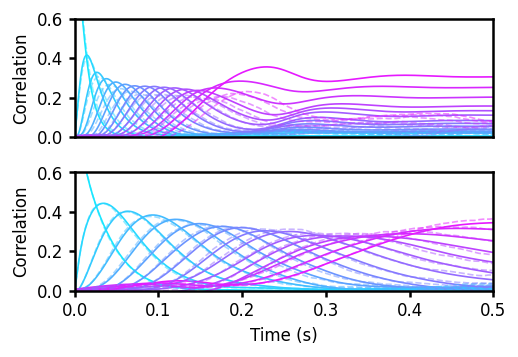

In [25]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5  # For major x-ticks
plt.rcParams['ytick.major.width'] = 1.5  # For major y-ticks
plt.rcParams['xtick.minor.width'] = 1.5  # For minor x-ticks, if you use them
plt.rcParams['ytick.minor.width'] = 1.5  # For minor y-ticks, if you use them


cmap = plt.cm.get_cmap('cool')
colors = [cmap(x) for x in np.linspace(0.1,0.9,16)]

fig, ax = plt.subplots(2,1,figsize=(4.5,3), dpi=120)
T = 0.5
dt = 1e-3
t = np.arange(0,T,dt)

# Plot fixed inputs
for i, m in enumerate(q_ext[0]):
    ax[0].plot(t,m, linewidth=1, c=colors[i]);
for i, m in enumerate(q_ext[1]):
    ax[1].plot(t,m, linewidth=1, c=colors[i]);
    
# Plot fluctuating input
for i, m in enumerate(q_ext_noisy[0]):
    ax[0].plot(t,m, linewidth=1, c=colors[i], linestyle='dashed', alpha=0.5);
for i, m in enumerate(q_ext_noisy[1]):
    ax[1].plot(t,m, linewidth=1, c=colors[i], linestyle='dashed', alpha=0.5);
    
for i,marker in enumerate(['o','D']):
    ax[i].scatter(1.1,0.85,color='k',marker=marker,alpha=0.3)
    ax[i].scatter(1.1,0.85,color='k',marker=marker,alpha=0.3)
    
for i in range(2):
    ax[i].set_xlim([0,0.5])
    ax[i].set_ylim([0,0.6])
    ax[i].set_ylabel("Correlation")
ax[0].set_xticks([])
ax[-1].set_xlabel("Time (s)")

plt.subplots_adjust(hspace=0.3, wspace=0.25)

fig.savefig("1e.pdf", dpi=150, bbox_inches='tight')

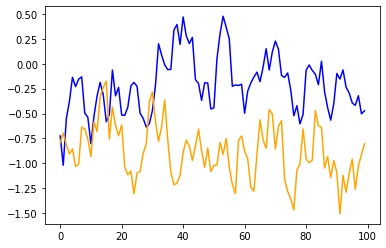

In [13]:
import matplotlib.pyplot as plt
plt.plot(I_ext[0][0] + xi_scaled[2][:100].get(), color='blue');
plt.plot(I_ext[0][1] + xi_scaled[int(N/2)+2][:100].get(), color='orange');

In [14]:
xi_scaled.std(axis=0).mean()

array(0.30009375)

In [16]:
1 * np.sqrt(2/tau_ou)

22.360679774997898